In [49]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt




In [50]:
df_tx_bank= pd.read_csv('./../transaction_data.csv')
df_tx_bank=df_tx_bank.head(1000).copy()


In [51]:
missing = df_tx_bank.isnull().sum()
missing

Transaction ID                      0
Sender Account ID                   0
Receiver Account ID                 0
Transaction Amount                  0
Transaction Type                    0
Timestamp                           0
Transaction Status                  0
Fraud Flag                          0
Geolocation (Latitude/Longitude)    0
Device Used                         0
Network Slice ID                    0
Latency (ms)                        0
Slice Bandwidth (Mbps)              0
PIN Code                            0
dtype: int64

In [52]:
df_tx_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction ID                    1000 non-null   object 
 1   Sender Account ID                 1000 non-null   object 
 2   Receiver Account ID               1000 non-null   object 
 3   Transaction Amount                1000 non-null   float64
 4   Transaction Type                  1000 non-null   object 
 5   Timestamp                         1000 non-null   object 
 6   Transaction Status                1000 non-null   object 
 7   Fraud Flag                        1000 non-null   bool   
 8   Geolocation (Latitude/Longitude)  1000 non-null   object 
 9   Device Used                       1000 non-null   object 
 10  Network Slice ID                  1000 non-null   object 
 11  Latency (ms)                      1000 non-null   int64  
 12  Slice B

In [53]:
grouped = df_tx_bank.groupby(['Sender Account ID', 'Timestamp' ])
counts = grouped.size().reset_index(name='transaction count')

multi_senders = counts[counts['transaction count']>1]
multi_senders

,Sender Account ID,Timestamp,transaction count


In [54]:
matching_values = df_tx_bank[df_tx_bank['Transaction ID'].duplicated()]

print(f"Found {len(matching_values)} matches")
print(matching_values['Transaction ID'].tolist())

Found 0 matches
[]


In [55]:
trans_status = df_tx_bank[df_tx_bank['Transaction Status'] == "Failed"]
trans_status

,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Transaction Status,Fraud Flag,Geolocation (Latitude/Longitude),Device Used,Network Slice ID,Latency (ms),Slice Bandwidth (Mbps),PIN Code
0,TXN9520068950,ACC14994,ACC16656,495.90,Deposit,2025-01-17 10:14:00,Failed,True,"34.0522 N, -74.006 W",Desktop,Slice3,10,179,3075
2,TXN4407425052,ACC56321,ACC92481,862.47,Withdrawal,2025-01-17 10:50:00,Failed,False,"48.8566 N, 2.3522 W",Mobile,Slice1,4,53,8039
5,TXN2515439857,ACC18381,ACC76710,449.56,Withdrawal,2025-01-17 10:01:00,Failed,False,"35.6895 N, 139.6917 W",Desktop,Slice1,14,191,4779
7,TXN3109277527,ACC48227,ACC93536,1135.80,Deposit,2025-01-17 10:56:00,Failed,True,"48.8566 N, -118.2437 W",Mobile,Slice2,11,69,8607
10,TXN6355066290,ACC14006,ACC27800,485.37,Transfer,2025-01-17 10:50:00,Failed,True,"34.0522 N, 37.6173 W",Mobile,Slice3,20,173,9631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,TXN9210129507,ACC98981,ACC73310,558.64,Deposit,2025-01-17 10:30:00,Failed,False,"48.8566 N, -74.006 W",Desktop,Slice1,4,204,4036
990,TXN2679491739,ACC69673,ACC60940,919.35,Deposit,2025-01-17 10:52:00,Failed,False,"48.8566 N, 37.6173 W",Mobile,Slice1,17,210,8981
991,TXN6073923771,ACC31273,ACC75160,1285.80,Withdrawal,2025-01-17 10:17:00,Failed,True,"34.0522 N, 2.3522 W",Desktop,Slice2,7,87,4938
996,TXN2215717837,ACC95972,ACC50750,483.36,Withdrawal,2025-01-17 11:00:00,Failed,True,"55.7558 N, 37.6173 W",Mobile,Slice2,12,56,1009


In [56]:
location_analysis = df_tx_bank[df_tx_bank['Transaction Status'] == "Failed"].groupby(['Geolocation (Latitude/Longitude)','Timestamp']).agg({
    'Transaction Status': ['count'],
    'Sender Account ID': 'nunique',  # How many unique users
    'Receiver Account ID': 'nunique',
    'Transaction Amount': ['sum'],
    'Transaction ID': 'count'
}).round(2)

location_analysis

Transaction Status  \
                                                                  count   
Geolocation (Latitude/Longitude) Timestamp                                
34.0522 N, -118.2437 W           2025-01-17 10:01:00                  1   
                                 2025-01-17 10:06:00                  1   
                                 2025-01-17 10:07:00                  1   
                                 2025-01-17 10:13:00                  1   
                                 2025-01-17 10:20:00                  1   
...                                                                 ...   
55.7558 N, 37.6173 W             2025-01-17 10:53:00                  1   
                                 2025-01-17 10:54:00                  1   
                                 2025-01-17 10:56:00                  2   
                                 2025-01-17 10:57:00                  1   
                                 2025-01-17 11:00:00                  1   

                                                     Sender Account ID  \
                                                               nunique   
Geolocation (Latitude/Longitude) Timestamp                               
34.0522 N, -118.2437 W           2025-01-17 10:01:00                 1   
                                 2025-01-17 10:06:00                 1   
                                 2025-01-17 10:07:00                 1   
                                 2025-01-17 10:13:00                 1   
                                 2025-01-17 10:20:00                 1   
...                                                                ...   
55.7558 N, 37.6173 W             2025-01-17 10:53:00                 1   
                                 2025-01-17 10:54:00                 1   
                                 2025-01-17 10:56:00                 2   
                                 2025-01-17 10:57:00                 1   
                                 2025-01-17 11:00:00                 1   

                                                     Receiver Account ID  \
                                                                 nunique   
Geolocation (Latitude/Longitude) Timestamp                                 
34.0522 N, -118.2437 W           2025-01-17 10:01:00                   1   
                                 2025-01-17 10:06:00                   1   
                                 2025-01-17 10:07:00                   1   
                                 2025-01-17 10:13:00                   1   
                                 2025-01-17 10:20:00                   1   
...                                                                  ...   
55.7558 N, 37.6173 W             2025-01-17 10:53:00                   1   
                                 2025-01-17 10:54:00                   1   
                                 2025-01-17 10:56:00                   2   
                                 2025-01-17 10:57:00                   1   
                                 2025-01-17 11:00:00                   1   

                                                     Transaction Amount  \
                                                                    sum   
Geolocation (Latitude/Longitude) Timestamp                                
34.0522 N, -118.2437 W           2025-01-17 10:01:00             872.85   
                                 2025-01-17 10:06:00              94.08   
                                 2025-01-17 10:07:00              58.69   
                                 2025-01-17 10:13:00             394.76   
                                 2025-01-17 10:20:00            1117.59   
...                                                                 ...   
55.7558 N, 37.6173 W             2025-01-17 10:53:00             526.37   
                                 2025-01-17 10:54:00             498.23   
                                 2025-01-17 10:56:00            1907.77   


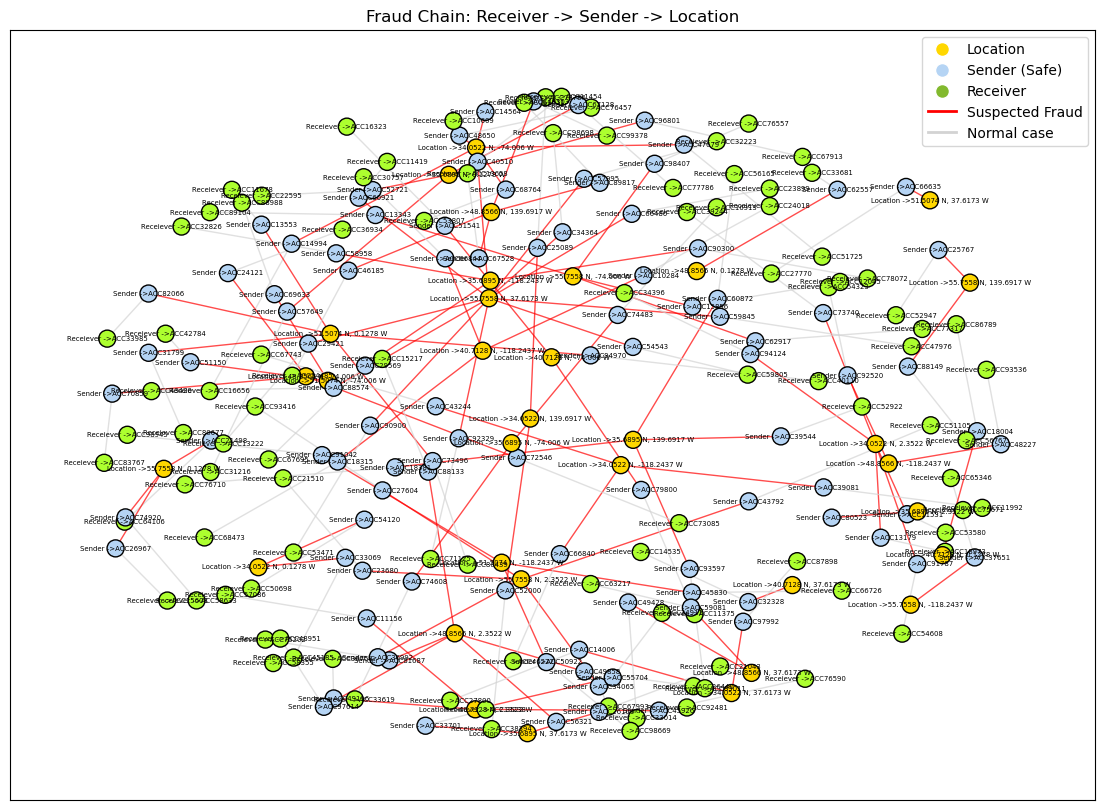

In [61]:

G = nx.Graph()

sub_df = df_tx_bank.head(100)

for _, row in sub_df.iterrows():
    s_acc = f"Sender ->{row['Sender Account ID']}"
    r_acc = f"Receiever ->{row['Receiver Account ID']}"
    loc = f"Location ->{row['Geolocation (Latitude/Longitude)']}"
    trans = f"amt ->{row['Transaction Amount']}"
    trans_status = f"status ->{row['Transaction Status']}"

    trans_id = f"trans_id ->{row['Transaction ID']}"
    G.add_node(s_acc, type='sender')
    G.add_node(r_acc, type='receiver')
    G.add_node(loc, type='location')


    G.add_edge(r_acc, s_acc)
    G.add_edge(s_acc, loc)
  

location_counts = df_tx_bank.groupby('Geolocation (Latitude/Longitude)')['Sender Account ID'].nunique()
hotspot_locations = location_counts[location_counts > 1].index.tolist()

if row['Geolocation (Latitude/Longitude)'] in hotspot_locations:
        current_edge_color = 'red'
else:
        current_edge_color = 'gray'

colors = []
for node, attr in G.nodes(data=True):
    if attr['type'] == 'location':
        colors.append('#FFD700') 
    elif attr['type'] == 'sender':
        colors.append('#B5D4F4') 
    else:
        colors.append('#ADFF2F') 

final_edge_colors = []
for u, v in G.edges():
 
    u_name = str(u)
    v_name = str(v)
    
    is_hotspot = False
    for loc_val in hotspot_locations:
        loc_str = f"Location ->{loc_val}"
        if (u_name == loc_str or v_name == loc_str):
            is_hotspot = True
            break
            
    if is_hotspot:
        final_edge_colors.append('red')
    else:
        final_edge_colors.append('#D3D3D3') 

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.3, seed=43)

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=150, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.7,edge_color=final_edge_colors, width=1)
nx.draw_networkx_labels(G, pos, font_size=5)

# Legend
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label='Location', markerfacecolor='#FFD700', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Sender (Safe)', markerfacecolor="#B5D4F4", markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Receiver', markerfacecolor="#82B92E", markersize=10),
    Line2D([0], [0], color='red', lw=2, label='Suspected Fraud'),
    Line2D([0], [0], color='#D3D3D3', lw=2, label='Normal case'),
]
plt.legend(handles=handles, loc='best')
plt.title("Fraud Chain: Receiver -> Sender -> Location")
plt.show()